<a href="https://colab.research.google.com/github/Ghalieddouib/Checkpoint-3/blob/main/MASI_algo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Charger les données
df = pd.read_excel('DATA MASI SC (1).xlsx')
df = df.sort_values('Date (GMT)').reset_index(drop=True)

# Calcul des moyennes mobiles
df['MM5'] = df['Last'].rolling(window=5).mean()
df['MM20'] = df['Last'].rolling(window=20).mean()

# Détection des Golden Cross
df['golden_cross'] = ((df['MM5'] > df['MM20']) & df['MM5'].notna() & df['MM20'].notna())
df.head(400)

,Date (GMT),Open,High,Low,Last,50,200,golden cross,variation,portefeuille,...,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,MM5,MM20,golden_cross
0,2002-01-02,3740.10,3777.00,3694.77,3694.96,NaN,NaN,NaN,NaN,1000000.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2002-01-03,3684.51,3694.96,3640.00,3640.00,NaN,NaN,NaN,-0.014874,985125.684716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2002-01-04,3641.08,3671.50,3640.00,3671.50,NaN,NaN,NaN,0.008654,993650.810834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2002-01-07,3670.56,3674.71,3662.56,3667.30,NaN,NaN,NaN,-0.001144,992514.127352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2002-01-08,3655.56,3657.54,3639.32,3641.65,NaN,NaN,NaN,-0.006994,985572.238942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3663.082,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2003-08-04,3525.06,3525.06,3517.63,3518.07,3499.6864,3232.27430,3499.6864,-0.001720,952126.680668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3520.750,3506.0025,True
396,2003-08-05,3516.92,3517.64,3507.92,3508.00,3504.1494,3234.20985,3504.1494,-0.002862,949401.346699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3520.362,3508.1580,True
397,2003-08-06,3514.42,3529.62,3514.42,3526.39,3508.7640,3236.21665,3508.7640,0.005242,954378.396519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3519.816,3511.4435,True
398,2003-08-07,3526.54,3527.26,3517.48,3517.76,3513.0380,3238.26590,3513.0380,-0.002447,952042.782601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3518.870,3514.1590,True


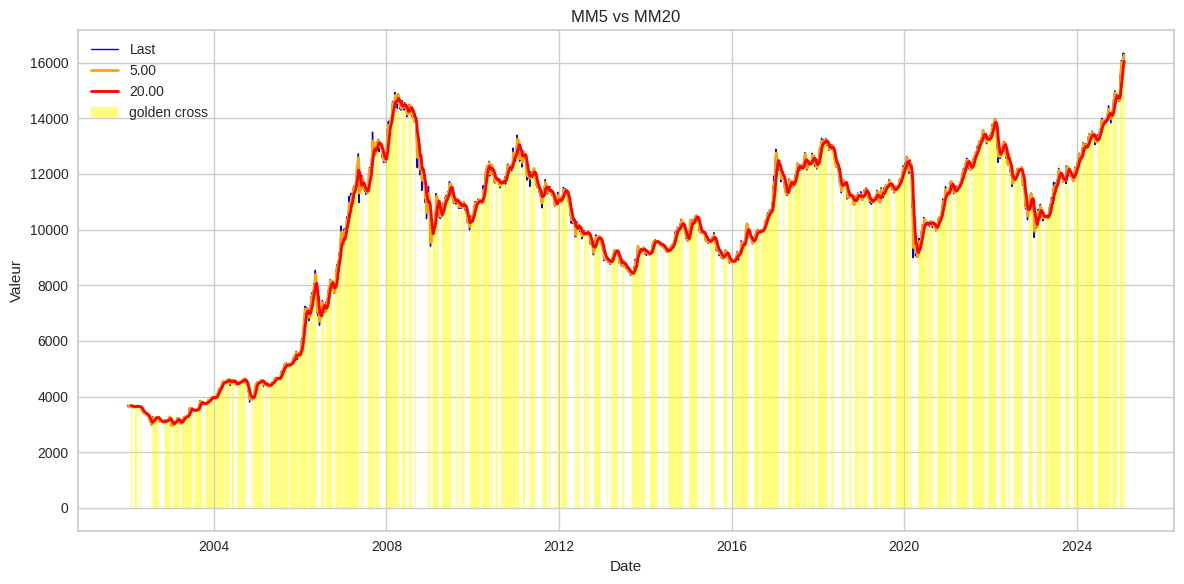

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date (GMT)'], df['Last'], label='Last', color='blue', linewidth=1)
plt.plot(df['Date (GMT)'], df[f'MM5'], label=f'5.00', color='orange', linewidth=2)
plt.plot(df['Date (GMT)'], df[f'MM20'], label=f'20.00', color='red', linewidth=2)

# Zones jaunes : là où golden_cross existe
#plt.fill_between(df['Date (GMT)'], 0, df['Last'], where=df['golden_cross'].notna(), color='yellow', alpha=0.5, label='golden cross')
plt.fill_between(df['Date (GMT)'], 0, df['Last'], where=df['golden_cross'], color='yellow', alpha=0.5, label='golden cross')

plt.title(f"MM5 vs MM20")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Paramétrage Stop/Loss & Take Profit(%) de l'utilisateur
tp_pct = float(input("Entrer le take profit en % (ex: 30 pour 30%) : ")) / 100
sl_pct = float(input("Entrer le stop loss en % (ex: 10 pour 10%) : ")) / 100

print(f"Paramètres choisis : TP = {tp_pct*100:.1f} %, SL = {sl_pct*100:.1f} %")
print(f"Ratio gain/perte : {tp_pct / sl_pct:.0f}:1")

#Initialisation du portefeuille
capital = 1_000_000
positions = []
open_trade = None
in_golden_cross = False  # état pour suivre si on est dans un GC

for i in range(1, len(df)):
    row = df.iloc[i]
    prev_row = df.iloc[i - 1]

    # Détection d'un nouveau golden cross
    is_new_gc = (row['MM5'] > row['MM20']) and (prev_row['MM5'] <= prev_row['MM20'])

    # Ouvrir un nouveau trade uniquement au début du golden cross
    if is_new_gc and open_trade is None:
        entry_price = row['Last']
        open_trade = {
            'entry_date': row['Date (GMT)'],
            'entry_price': entry_price,
            'take_profit': entry_price * (1 + tp_pct),
            'stop_loss': entry_price * (1 - sl_pct),
            'exit_date': None,
            'exit_price': None,
            'status': 'open'
        }
        in_golden_cross = True  # on entre dans une zone GC

    # Suivi de position
    if open_trade:
        current_price = row['Last']
        hit_tp = current_price >= open_trade['take_profit']
        hit_sl = current_price <= open_trade['stop_loss']
        end_of_gc = row['MM5'] <= row['MM20']

        if hit_tp or hit_sl or end_of_gc:
            open_trade['exit_date'] = row['Date (GMT)']
            open_trade['exit_price'] = current_price
            open_trade['status'] = 'tp' if hit_tp else ('sl' if hit_sl else 'neutral')
            pnl = open_trade['exit_price'] - open_trade['entry_price']
            capital += pnl
            positions.append(open_trade)
            open_trade = None
            in_golden_cross = False  # on sort de la zone GC


Entrer le take profit en % (ex: 30 pour 30%) : 30
Entrer le stop loss en % (ex: 10 pour 10%) : 10
Paramètres choisis : TP = 30.0 %, SL = 10.0 %
Ratio gain/perte : 3:1


In [ ]:
# Nombre de Golden Cross détectés
df['golden_cross'] = (df['MM5'] > df['MM20']) & (df['MM5'].shift(1) <= df['MM20'].shift(1))
nb_golden_crosses = df['golden_cross'].sum()

# Nombre de trades ouverts
nb_trades = len(positions)

# Affichage
print(f"Nombre de Golden Cross détectés : {nb_golden_crosses}")
print(f"Nombre de trades ouverts        : {nb_trades}")

if nb_golden_crosses != nb_trades:
    print("Attention : le nombre de trades ne correspond pas au nombre de Golden Cross !")
else:
    print("Le nombre de trades correspond parfaitement au nombre de Golden Cross.")


Nombre de Golden Cross détectés : 139
Nombre de trades ouverts        : 138
Attention : le nombre de trades ne correspond pas au nombre de Golden Cross !


In [ ]:
# Convertir la liste des positions en DataFrame
result_df = pd.DataFrame(positions)

# Calcul du profit brut total
profit_total = result_df['exit_price'] - result_df['entry_price']
result_df['pnl'] = profit_total
total_profit = result_df['pnl'].sum()

# Compter les types de trades
n_tp = (result_df['status'] == 'tp').sum()
n_sl = (result_df['status'] == 'sl').sum()
n_neutral = (result_df['status'] == 'neutral').sum()
n_total = len(result_df)

# Taux de réussite
success_rate = (n_tp / n_total) * 100

# Affichage des résultats
print(f"Résumé de la stratégie: ")
print(f"Nombre total de trades: {n_total}")
print(f"Take Profit (tp): {n_tp}")
print(f"Stop Loss (sl): {n_sl}")
print(f"Clôture neutre: {n_neutral}")
print(f"Profit net total: {total_profit:.2f} points")
print(f"Taux de réussite (TP): {success_rate:.2f} %")
print(f"Capital final: {capital:.2f} EUR")


Résumé de la stratégie: 
Nombre total de trades: 138
Take Profit (tp): 1
Stop Loss (sl): 0
Clôture neutre: 137
Profit net total: 22032.79 points
Taux de réussite (TP): 0.72 %
Capital final: 1022032.79 EUR


/tmp/ipython-input-533217090.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999983.93' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.loc[i, 'capital'] = result_df.loc[i - 1, 'capital'] + pnl


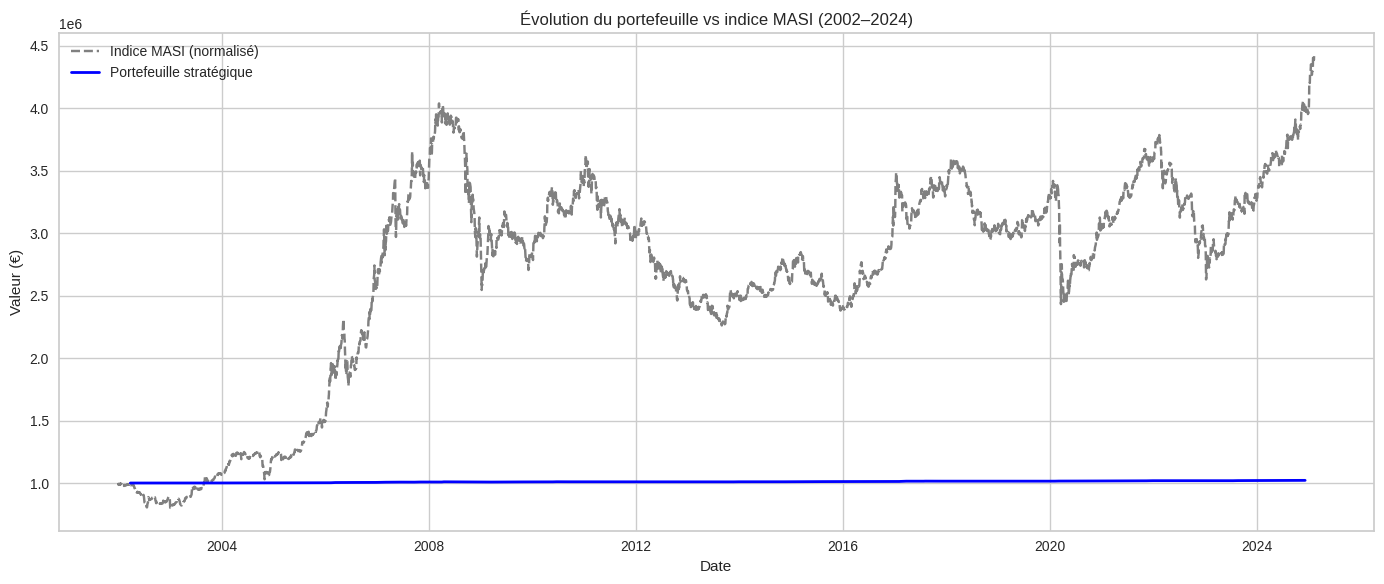

In [ ]:
#Recalcul du capital au fil des trades
result_df = pd.DataFrame(positions)
result_df['capital'] = capital = 1_000_000
for i in range(1, len(result_df)):
    pnl = result_df.loc[i - 1, 'exit_price'] - result_df.loc[i - 1, 'entry_price']
    result_df.loc[i, 'capital'] = result_df.loc[i - 1, 'capital'] + pnl

#courbe MASI
df_sorted = df.sort_values('Date (GMT)').copy()
masi_base = df_sorted['Last'].iloc[0]
df_sorted['masi_norm'] = df_sorted['Last'] / masi_base * 1_000_000

plt.figure(figsize=(14, 6))

# Indice MASI (normalisé à 1M)
plt.plot(df_sorted['Date (GMT)'], df_sorted['masi_norm'],
         label='Indice MASI (normalisé)', color='gray', linestyle='--')

# Capital du portefeuille
plt.plot(result_df['exit_date'], result_df['capital'],
         label='Portefeuille stratégique', color='blue', linewidth=2)

plt.title("Évolution du portefeuille vs indice MASI (2002–2024)")
plt.xlabel("Date")
plt.ylabel("Valeur (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()